## Descripcion:
Modulador BPSK solo para Pluto

Incluye:
 - Generacion de Señal de datos aleatoria
 - Modulacion bpsk con la posibilidad de usar (rect, rc, rcc)
 - Diagrama de ojo señal a transmitir
 - FFT señal a transmitir
 - Filtro pasa bajos
 - Diagrama de ojo señal recibida
 - FFT señal recibida
 - Muestreo y umbralizado
 - Grafica BER vs SNR (con correcion por la disminucion de la potencia de ruido debido a los filtros)

Version: 3

## Importamos librerias

In [1]:
#!pip install scikit-dsp-comm

In [2]:
from sk_dsp_comm import digitalcom as dc
from sk_dsp_comm import sigsys as ss
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq
from scipy.signal import butter, lfilter
from scipy.signal import kaiserord, firwin, freqz
from scipy import signal
%matplotlib notebook

## Generamos una señal a transmitir

<IPython.core.display.Javascript object>


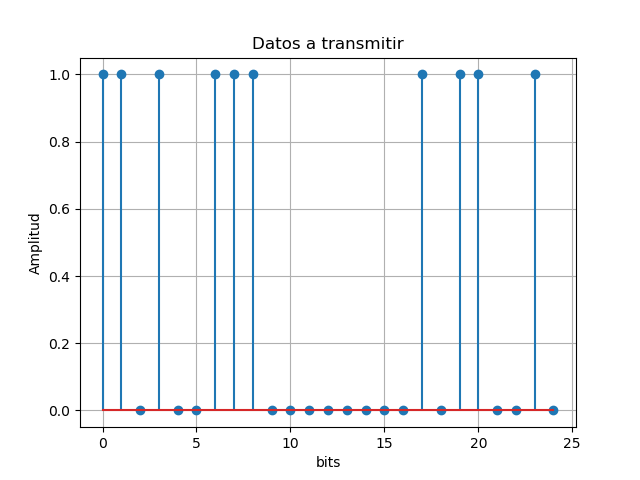

In [3]:
NroBits = 1000     # Numero de bits a transmitir
fs = 521e3         # Frecuencia de muestreo [Hz]
ts = 1/fs          # Periodo de muestreo [sec]
Tbit = 0.000521    # Tiempo del bit [sec]
Ns = int(fs*Tbit)  # Muestras por bit de dato

TxData = np.random.randint(2,size=NroBits)

plt.figure()
plt.stem(TxData[0:25], use_line_collection=True)
plt.title("Datos a transmitir")
plt.xlabel("bits")
plt.ylabel("Amplitud")
plt.grid()
plt.show()

## Generamos la señal BPSK

<IPython.core.display.Javascript object>


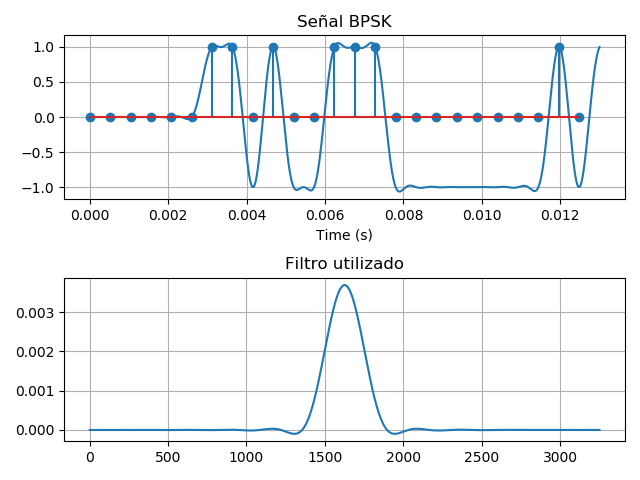

In [4]:
# Parametros para la BPSK
Pulse = 'rc'  # Tipo de filtro a utilizar [rect, rc, rcc]
Alpha = 1     # Parametro alpha del filtro

# Generacion de la BPSK
Signal_NRZ, Pulse_shape = ss.NRZ_bits2(TxData, Ns, pulse=Pulse, alpha=Alpha)
t = np.arange(len(Signal_NRZ))

# Ajuste del retraso generado, solo a fin de poder graficar correctamente
Desfasaje = 6
Aux_TxData = np.zeros(Desfasaje,dtype=int).tolist() + TxData.tolist() 

plt.figure()
plt.subplot(211)
plt.plot(ts*t[0:Ns*25], Signal_NRZ[0:Ns*25])
plt.stem(ts*t[0:Ns*25:Ns], Aux_TxData[0:25], use_line_collection=True)
plt.title("Señal BPSK")
plt.xlabel('Time (s)')
plt.grid()
plt.subplot(212)
plt.plot(Pulse_shape)
plt.title("Filtro utilizado")
plt.grid()
plt.tight_layout()
plt.show()

## Diagrama de ojo, señal

<IPython.core.display.Javascript object>


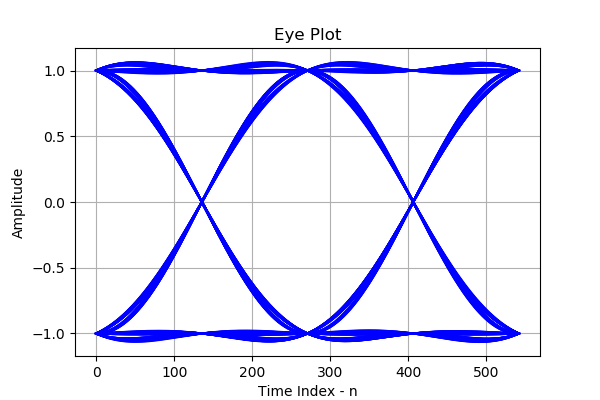

In [5]:
L = Ns*2        # display length in samples (usually two symbols)
S = 0           # start index
dc.eye_plot(Signal_NRZ[Ns*100:Ns*400],L,S)  # Para mayor velocidad solo grafico un intervalo de 1000 simbolos
plt.show()

<IPython.core.display.Javascript object>


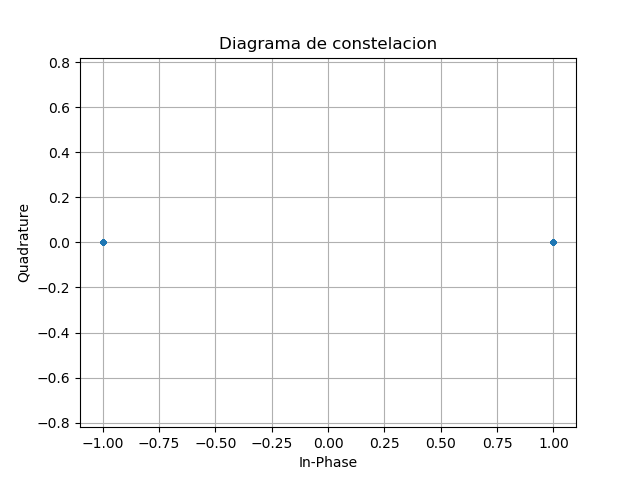

In [15]:
yI,yQ = dc.scatter(Signal_NRZ,Ns,Ns*6)
plt.figure()
plt.plot(yI,yQ,'.')
plt.grid()
plt.title("Diagrama de constelacion")
plt.xlabel('In-Phase')
plt.ylabel('Quadrature')
plt.axis('equal')
plt.show()

## FFT, Señal transmitida

<IPython.core.display.Javascript object>


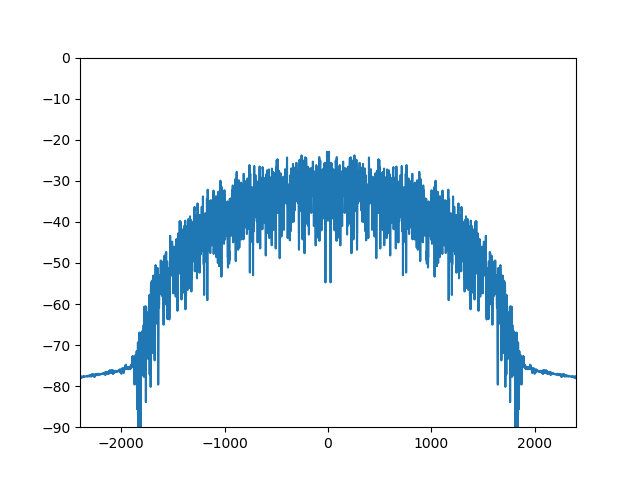

In [6]:
plt.figure()
N = Signal_NRZ.shape[0]
Y = fft(Signal_NRZ)/N
frq = fftfreq(N, 1/fs)
plt.plot(frq, 20*np.log10(abs(Y)))
plt.xlim(-int(1/Tbit) - int((1/Tbit)*0.25), int(1/Tbit) + int((1/Tbit)*0.25))
plt.ylim(-90,0)
plt.show()

In [ ]:
##titulo

In [ ]:
#del(sdr)

In [7]:
import adi

sdr = adi.Pluto()

sdr.rx_lo = int(1e9) # [Hz]
sdr.rx_buffer_size = len(Signal_NRZ)

sdr.tx_destroy_buffer()
sdr.tx_lo = int(1e9) # [Hz]
sdr.tx_cyclic_buffer = True
sdr.tx_hardwaregain_chan0 = -10
sdr.gain_control_mode_cahn0 = "slow_attack"
sdr.sample_rate = fs # [Hz]

fs_pluto = int(sdr.sample_rate)
print('fs =',fs_pluto)

# Send data
sdr.tx(Signal_NRZ*2**14 + 1j*0)

fs = 520999


## Recibo la señal

(271000,)


<IPython.core.display.Javascript object>


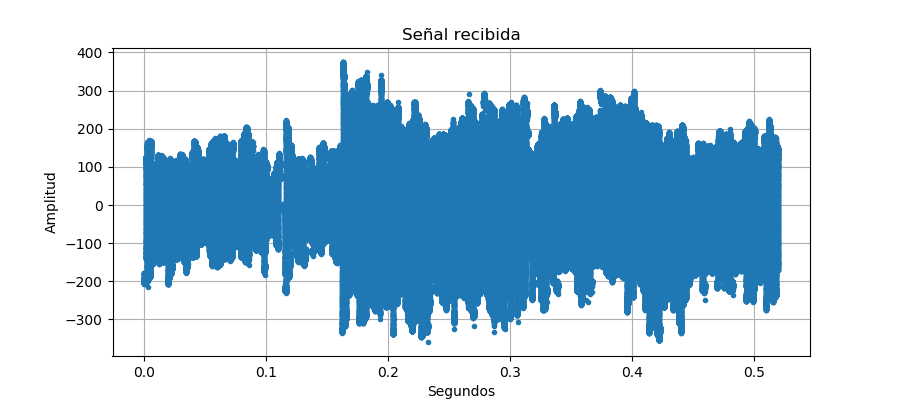

In [49]:
#signal_rx = sdr.rx()
print(signal_rx.shape)
plt.figure(figsize=(9,4))
plt.plot(t*ts, np.real(signal_rx),'.')
plt.title("Señal recibida")
plt.xlabel("Segundos")
plt.ylabel("Amplitud")
#plt.xlim(0,0.01)
plt.grid()

## FFT, Señal recibida

<IPython.core.display.Javascript object>


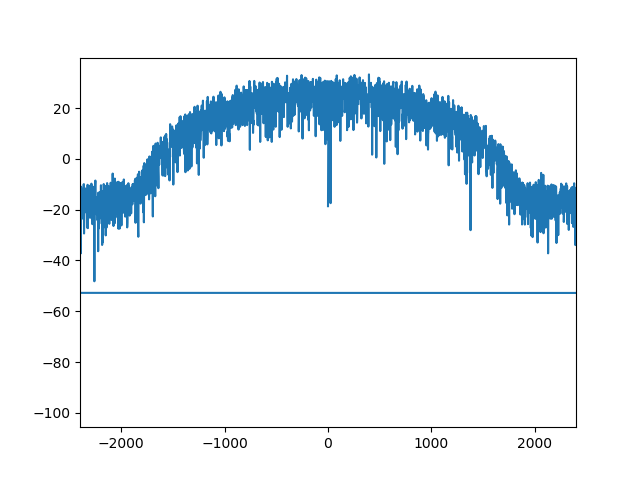

In [50]:
plt.figure()
N = signal_rx.shape[0]
Y = fft(signal_rx)/N
frq = fftfreq(N, 1/fs)
plt.plot(frq, 20*np.log10(abs(Y)))
plt.xlim(-int(1/Tbit) - int((1/Tbit)*0.25), int(1/Tbit) + int((1/Tbit)*0.25))
#plt.ylim(-90,0)
plt.show()

## Demodulacion, Filtro pasa bajos


<IPython.core.display.Javascript object>


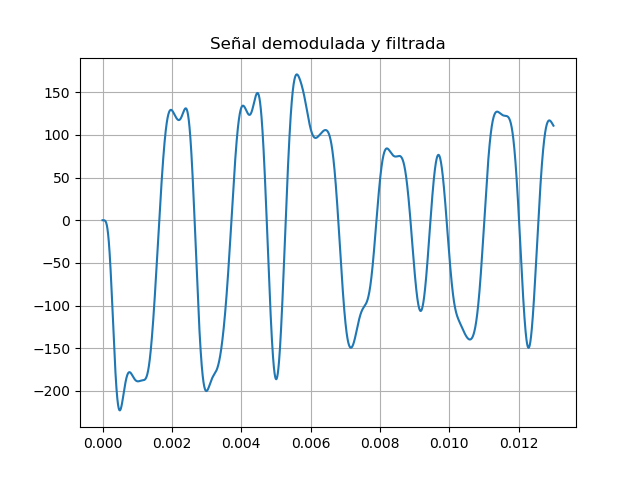

Text(0.5, 1.0, 'Señal demodulada y filtrada')

In [51]:
# Filtro pasa bajos
nyq = fs/2
low = 2000 / nyq
order = 5
b, a = butter(order, low, btype='low')
y = lfilter(b, a, signal_rx)

#npower_rx_demodulado = np.sum(y**2) / len(y)
#print("npower_rx_demodulado:", npower_rx_demodulado)

plt.figure()
plt.plot(ts*t[0:Ns*25], y[0:Ns*25])
plt.grid()
plt.title("Señal demodulada y filtrada")

## Diagrama de ojo, señal demodulada

<IPython.core.display.Javascript object>


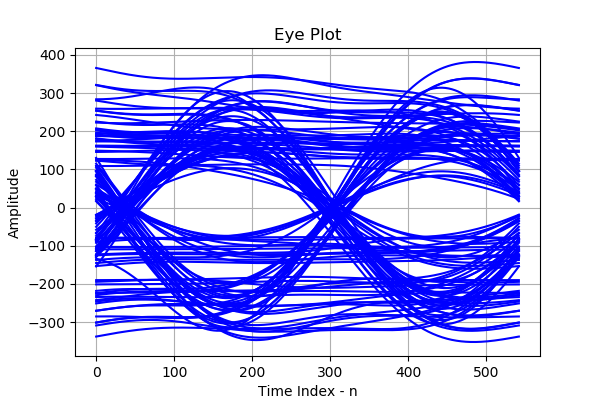

In [52]:
L = Ns*2        # display length in samples (usually two symbols)
S = 0           # start index
dc.eye_plot(y[Ns*250:Ns*500],L,S) # Para mayor velocidad solo grafico un intervalo de 1000 simbolos
plt.show()

<IPython.core.display.Javascript object>


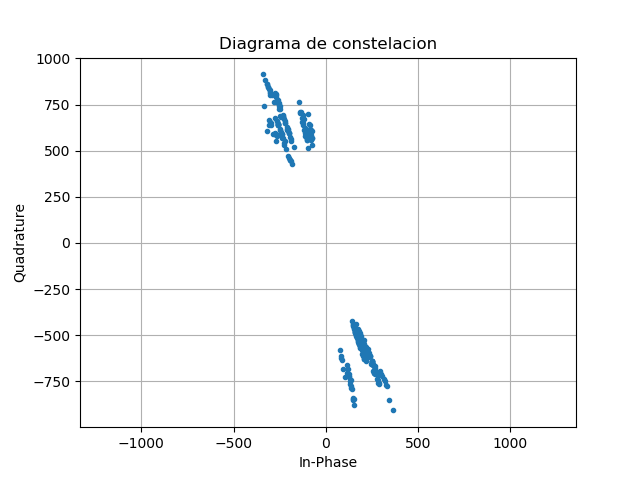

In [53]:
yI,yQ = dc.scatter(y[Ns*250:Ns*500],Ns,Ns*6+170)
plt.figure()
plt.plot(yI,yQ,'.')
plt.grid()
plt.title("Diagrama de constelacion")
plt.xlabel('In-Phase')
plt.ylabel('Quadrature')
plt.axis('equal')
plt.show()

<IPython.core.display.Javascript object>


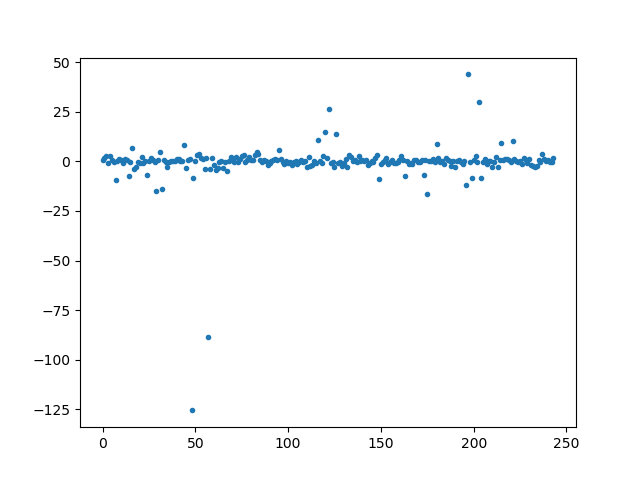

In [45]:
plt.figure()
plt.plot(np.tan(yI,yQ),'.')

## FFT, señal demodulada

<IPython.core.display.Javascript object>


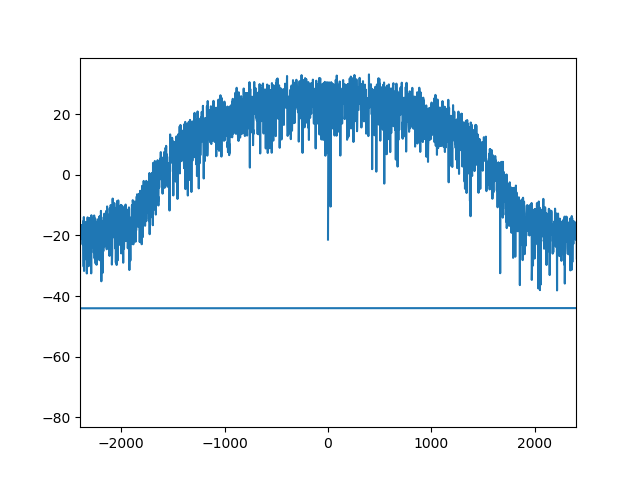

In [47]:
plt.figure()
N = y.shape[0]
Y = fft(y)/N
frq = fftfreq(N, 1/fs)
plt.plot(frq, 20*np.log10(abs(Y)))
plt.xlim(-int(1/Tbit) - int((1/Tbit)*0.25), int(1/Tbit) + int((1/Tbit)*0.25))
#plt.ylim(-80,0)
plt.show()

## Muestreo y umbralizado

<IPython.core.display.Javascript object>


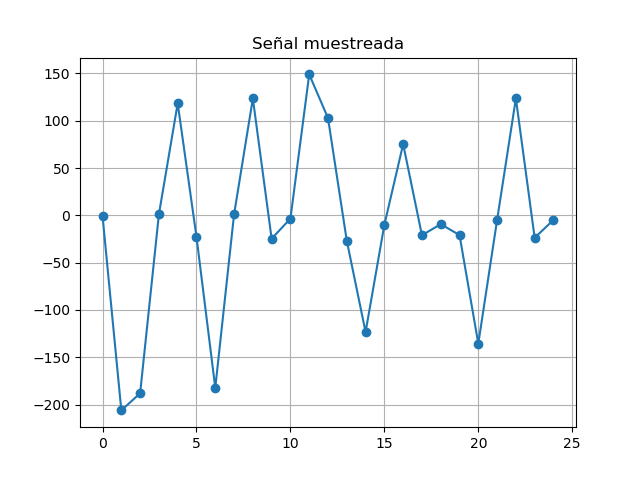

Los bits recibidos no son iguales a los transmitidos
BER:  0.48893360160965793


C:\Users\PC-Admin\Anaconda\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [48]:
# Centro del diagrama de ojo:
Eye_center = 40
ys = y[Eye_center::Ns]

plt.figure()
plt.plot(ys[0:25], '-o')
plt.grid()
plt.title("Señal muestreada")

# Umbralizado
RxData = 1*(ys > 0)

# Verificacion de bits recibidos
if ((TxData[:-Desfasaje]==RxData[Desfasaje:]).all()):
    print("Todos los bits recibidos son iguales a los transmitidos")
else:
    print("Los bits recibidos no son iguales a los transmitidos")
    
# Calculo del BER
ber = np.sum(np.abs(RxData[Desfasaje:] - TxData[:-Desfasaje]))/len(TxData[:-Desfasaje])
print("BER: ",ber)